# Imports

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image
import os
import sys
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from helpers import *
from window_patch_extend import *

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

-----------------------
# Loading augmented data

In [3]:
mode = 'rgb'

#We directly import images from the augmented dataset

root_dir = "./augmented_training/"

image_dir = root_dir + "satellite/"
gt_dir = root_dir + "ground_truth/"


imgs,nb_imgs = load_all(image_dir,mode)
gt_imgs,nb_gt_imgs = load_all(gt_dir,mode)

loading 800 images
loading 800 images


In [4]:
imgs[0].shape

(400, 400, 3)

# Parameters

In [5]:
batch_size = 128
epochs = 30
img_size = 400
test_img_size = 608
window_size = 72
patch_size = 16

# Example of use of helpers methods

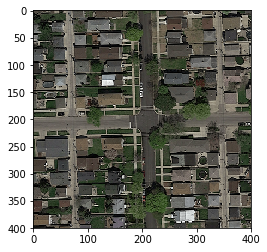

In [6]:
plt.imshow(imgs[0])

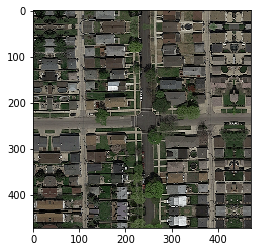

In [7]:
plt.imshow(extend_img(imgs[0],window_size//2))

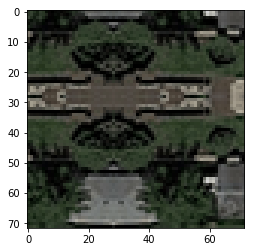

In [8]:
win = windows_from_img(imgs[0],window_size,patch_size)
plt.imshow(win[0])

# Generation of training and test sets

In [9]:
#shuffle images
imgs = np.asarray(imgs)
gt_imgs = np.asarray(gt_imgs)

per = np.random.permutation(imgs.shape[0])

imgs = imgs[per]
gt_imgs = gt_imgs[per]

In [10]:
'''training set'''
windows = []
labels = []

#We take as training set images from 0 to 200
#If you take more becarefull with memory overflow
for i in range(0, 100):
    windows += windows_from_img(imgs[i], window_size, patch_size)
    labels += labels_from_gt_img(gt_imgs[i], window_size, patch_size)

windows = np.asarray(windows)
labels = np.asarray(labels)
print(windows.shape, labels.shape)

#shuffle windows and labels in same permutation
per = np.random.permutation(windows.shape[0])
windows = windows[per]
labels = labels[per]

MemoryError: 

In [ ]:
'''testing set'''
windows_test = []
labels_test = []

for i in range(751, 800):
    windows_test += windows_from_img(imgs[i], window_size, patch_size)
    labels_test += labels_from_gt_img(gt_imgs[i], window_size, patch_size)

windows_test = np.asarray(windows_test)
labels_test = np.asarray(labels_test)
print(windows_test.shape, labels_test.shape)

per = np.random.permutation(windows_test.shape[0])
windows_test = windows_test[per]
labels_test = labels_test[per]

In [ ]:
iii = np.random.randint(0, 100)
print(labels[iii])
plt.imshow(windows[iii])

# Generation of neural net

In [ ]:
#Command to save the neural net weights at each epoch
weigh_save_file = 'weights-Adam-CNNPaul-big-last-300.hdf5'
cp = keras.callbacks.ModelCheckpoint(weigh_save_file, monitor='acc', save_best_only=True, save_weights_only=True)

In [19]:
reg = 1e-6

model = Sequential()

model.add(Conv2D(32, (3, 3),  padding = 'same' ,input_shape=(window_size, window_size, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512 , kernel_regularizer=l2(reg)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(reg)))

In [20]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, patience=5, min_lr=0.0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 36, 36, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
__________

# Training of the neural net

In [66]:
try:
    model.fit(windows, labels, batch_size=batch_size, epochs=epochs, callbacks=[cp, reduce_lr], validation_data=(windows_test, labels_test))
except KeyboardInterrupt:
    pass

Epoch 1/30
187500/187500 [==============================] - 325s 2ms/step - loss: 0.1640 - acc: 0.9471


c:\users\thibaud\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:890: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/30
187500/187500 [==============================] - 320s 2ms/step - loss: 0.1503 - acc: 0.9512
Epoch 3/30
187500/187500 [==============================] - 329s 2ms/step - loss: 0.1439 - acc: 0.9539
Epoch 4/30
187500/187500 [==============================] - 333s 2ms/step - loss: 0.1392 - acc: 0.9559
Epoch 5/30
187500/187500 [==============================] - 334s 2ms/step - loss: 0.1337 - acc: 0.9579
Epoch 6/30
187500/187500 [==============================] - 335s 2ms/step - loss: 0.1289 - acc: 0.9594
Epoch 7/30
187500/187500 [==============================] - 336s 2ms/step - loss: 0.1259 - acc: 0.9612
Epoch 8/30
187500/187500 [==============================] - 336s 2ms/step - loss: 0.1238 - acc: 0.9617
Epoch 9/30
187500/187500 [==============================] - 338s 2ms/step - loss: 0.1193 - acc: 0.9636
Epoch 10/30
187500/187500 [==============================] - 347s 2ms/step - loss: 0.1166 - acc: 0.9643
Epoch 11/30
187500/187500 [==============================] - 360s 2ms/st

KeyboardInterrupt: 

# Prediction visualisation on test set

In [70]:
test_windows = windows_from_img(imgs[150], window_size, patch_size)
test_windows = np.asarray(test_windows)

pred = model.predict(test_windows, batch_size)

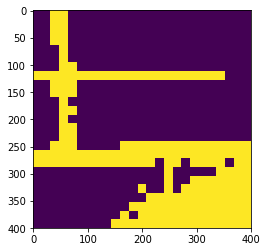

In [71]:
plt.imshow(prediction_to_img(pred, img_size, patch_size))

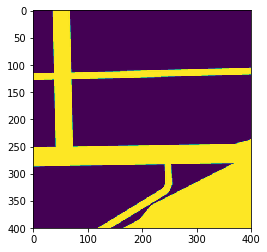

In [72]:
plt.imshow(gt_imgs[150])

# Statistics

In [73]:
def predict_window_set(to_predict_windows, batch_size, threshold=0.5):
    #x_test is the set of image, is a list
    return (model.predict(to_predict_windows, batch_size) > threshold).astype(int)


In [76]:
from sklearn.metrics import classification_report
test_predictions = predict_window_set(windows_test, batch_size, threshold=0.4)

In [77]:
print(classification_report(labels_test, test_predictions))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98     24948
          1       0.88      0.99      0.93      5677

avg / total       0.98      0.97      0.97     30625



# Filter Analysis

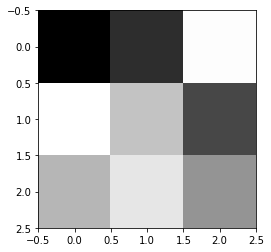

In [87]:
def map_(a):
    min_ = np.min(a)
    max_ = np.max(a)
    return (a - min_) / (max_ - min_)

plt.imshow(model.layers[0].get_weights()[0][:, :, 2, 11], cmap='Greys_r')

In [81]:
from scipy.signal import convolve2d

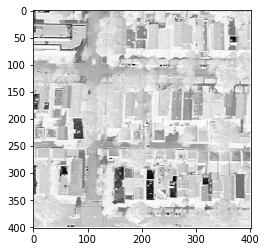

In [82]:
filter_0_0 = model.get_weights()[0][:, :, :, 25]
f_r = convolve2d(imgs[0][:, :, 0], filter_0_0[:, :, 0])
f_g = convolve2d(imgs[0][:, :, 1], filter_0_0[:, :, 1])
f_b = convolve2d(imgs[0][:, :, 2], filter_0_0[:, :, 2])
f = np.zeros((f_r.shape[0], f_r.shape[1], 3))
f[:, :, 0] = f_r
f[:, :, 1] = f_g
f[:, :, 2] = f_b
plt.imshow(f_r, cmap='Greys_r')

--------------------------
# Predict

In [83]:
nb_pred = 50
pred_path = './test_set_images/test_'
save_path = root_dir + 'prediction/'

if not os.path.exists(save_path):
        os.makedirs(save_path)

for i in range(1,nb_pred+1):
    to_predict_img = load_image(pred_path+ str(i)+'/test_'+str(i)+'.png', mode)
    to_predict_windows = windows_from_img(to_predict_img, window_size, patch_size)
    to_predict_windows = np.asarray(to_predict_windows)
    pred = model.predict(to_predict_windows, batch_size)
    save_image(save_path + 'pred_' + str(i) + '.png', prediction_to_img(pred, test_img_size, patch_size, threshold=0.4))